In [1]:
import sys
import pandas as pd
import numpy as np
import datetime
import requests
import numpy as np
from pandas import ExcelWriter
import os
import glob
import pytz
from dateutil.tz import gettz
import timeit
import matplotlib.pyplot as plt
# from datetime import datetime
from datetime import timedelta
import time
pd.set_option('display.max_rows', None)

In [2]:
def read_data(devid, acc_token, address, start_time, end_time, descriptors):

    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

    if r2:
        df = pd.DataFrame([])

        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            
            df1.reset_index(drop=False, inplace=True)
            df1['ts'] = pd.to_datetime(df1['ts'], unit='ms')
            df1 = df1.sort_values(by=['ts'])
            df1.reset_index(drop=True, inplace=True)
            df1.set_index('ts', inplace=True, drop=True)
            
            for col in df1.columns:
                df1[col] = df1[col].astype('float')
                
            
            df = pd.concat([df, df1], axis=1)


        if df.empty:
            df = pd.DataFrame([])
    else:
        df = pd.DataFrame([])
        print('Empty json!')
    return df


In [70]:
devname = '000.888.000126'
descriptors = 'ppb,tmp,hmd'


# start_time = '1620248400000'
start_time = '1620594000000'
end_time = '1620853200000'


address =  "https://m3.meazon.com"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'a.andrikopoulos19@meazon.com', 'password': 'andrikopMeazon13'}).json()

# acc_token is the token to be used in the next request
acc_token = 'Bearer' + ' ' + r['token']

# get devid by serial name
r1 = requests.get(
    url=address + "/api/tenant/devices?deviceName=" + devname,
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

devid = r1['id']['id']

df = read_data(devid, acc_token, address, start_time, end_time, descriptors)

df = df.resample('1T').mean()
df = df.fillna(method='ffill')
df.loc[df['tmp']<0]= np.nan
df = df.dropna()

In [71]:
devname = '000.888.000133'
descriptors = 'bindc,illu'

# get devid by serial name
r1 = requests.get(
    url=address + "/api/tenant/devices?deviceName=" + devname,
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

devid = r1['id']['id']

df2 = read_data(devid, acc_token, address, start_time, end_time, descriptors)

df2 = df2.resample('1T').max()
df2 = df2.fillna(method='ffill')
df2 = df2.dropna()

In [72]:
df = pd.concat([df,df2],axis=1)
df.rename(columns={'bindc':'Motion','illu':'Illuminance','tmp':'Temperature','hmd':'Humidity','ppb':'Air quality'},inplace=True)
df = df.dropna()
df.describe()

,Air quality,Temperature,Humidity,Motion,Illuminance
count,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000
mean,250.027894,24.929103,32.446792,0.189214,19733.547652
std,300.203442,0.293674,3.685904,0.391724,12405.622024
min,0.000000,24.400000,23.300000,0.000000,6433.000000
25%,101.000000,24.700000,30.200000,0.000000,6453.000000
50%,228.000000,24.900000,32.700000,0.000000,22981.000000
75%,308.000000,25.100000,34.800000,0.000000,31480.000000
max,2699.000000,26.100000,39.800000,1.000000,38482.000000


In [68]:
# fig = plt.figure(figsize=[12,8])
# plt.plot(df['bindc'])
# fig = plt.figure(figsize=[12,8])

# plt.plot(df['ppb'])

Text(0.5, 1, 'Correlation heatmap')

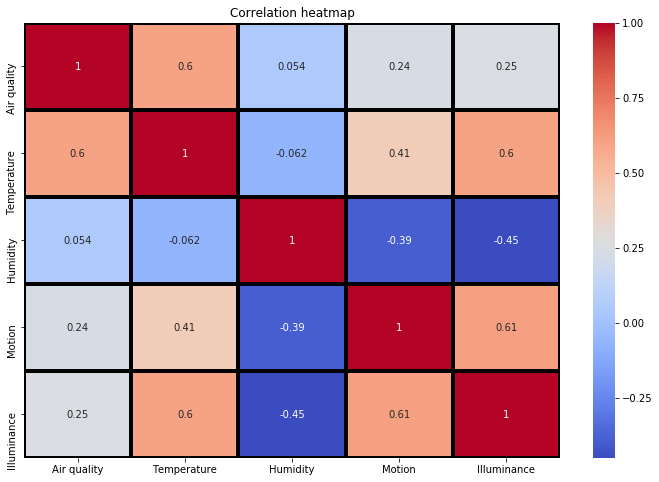

In [76]:
import seaborn as sns
fig = plt.figure(figsize=[12,8])
ax = sns.heatmap(df.corr(), annot = True,cmap= 'coolwarm',linewidths=3, linecolor='black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Correlation heatmap')


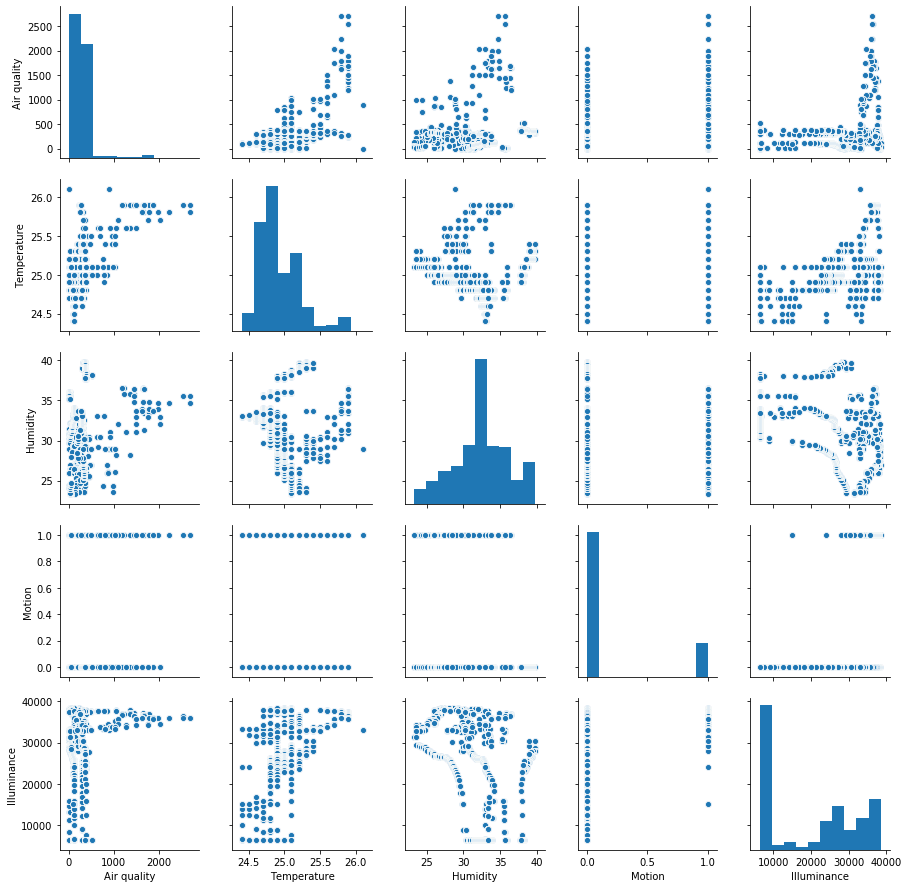

In [78]:
sns.pairplot(df)


In [66]:
from scipy.stats import pearsonr

import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [121]:
# lagged_correlation = pd.DataFrame.from_dict(
#     {x: [df['ppb'].corr(df[x].shift(-t)) for t in range(40)] for x in df.columns})
# lagged_correlation